In [1]:
import numpy as np
import pandas as pd
import nltk
import scipy as sp
import sklearn as sk
import os,time,re,string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics

* 大概思路：利用正负面描述的 **词语频率** 预测Amazon的商品评价
    1. 读取文字描述，查看大概数据情况
    2. 整理标签(>3 stars = positive)
    3. 整理summary文字，并建立语料库
    4. 建模
    5. 结果

# 1. Data Exploration

In [2]:
review_raw = pd.read_csv('./data/Reviews.csv')

In [3]:
review_raw.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
review_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
review_raw.isnull().sum(axis=0)

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
review_raw.Score.unique().shape[0]

5

In [7]:
n_samples = review_raw.shape[0]
n_samples

568454

In [8]:
df_uni = pd.DataFrame(index=range(10),
                      columns=['Feature','No. of NAs','No. of Unique Values','# of total samples','Unique_Percentage(%)'])


In [9]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [11]:
review_raw.columns.values

array(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype=object)

In [12]:
for i,feat in enumerate(review_raw.columns.values):
    feat_na = review_raw[feat].isnull().sum(axis=0)
    feat_uni = review_raw[feat].unique().shape[0]
    perc = feat_uni/n_samples * 100
    df_uni.iloc[i,:] = [feat, feat_na,feat_uni, n_samples, perc]

In [13]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,Id,0,568454,568454,100
1,ProductId,0,74258,568454,13.0632
2,UserId,0,256059,568454,45.0448
3,ProfileName,16,218417,568454,38.423
4,HelpfulnessNumerator,0,231,568454,0.0406365
5,HelpfulnessDenominator,0,234,568454,0.0411643
6,Score,0,5,568454,0.000879579
7,Time,0,3168,568454,0.557301
8,Summary,27,295743,568454,52.0258
9,Text,0,393579,568454,69.2367


In [14]:
review = review_raw.dropna()

In [15]:
review.shape

(568411, 10)

# 2. 整理label, 作为正负评价的标签
* 将结果分为两类: positive (score > 3) and negative (score <= 3)

In [16]:
label = review['Score'].apply(lambda x: 1 if x>3 else 0 )

In [17]:
label.head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

# 3 整理summary文字栏

* 去标点等符号
* 分词
* stopwords,去掉stopwords
* 词干提取Stemming与词形还原Lemmatization
* 清洗结果对比

In [18]:
summary = review['Summary']
summary.head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

## 3.1 数据清洗: 去掉标点符号
* 不要忘记import string
* import string
* string.punctuation

In [19]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
trantable = str.maketrans('','',string.punctuation)
def data_clean(text):
    text = text.lower()
    text_clean = text.translate(trantable)
    return text_clean

In [21]:
# test
l1 = 'hi, whats up*^@^*&!@#...'
data_clean(l1)

'hi whats up'

# Issue 1 -  str.maketrans('','',string.punctuation)
```python
import string
# This uses the 3-argument version of str.maketrans with arguments (x, y, z) where 'x' and 'y'
# must be equal-length strings and characters in 'x' are replaced by characters in 'y'. 
# 'z' is a string(string.punctuation here) where each character in the string is mapped to None
translator = str.maketrans('', '', string.punctuation)
s = 'string with "punctuation" inside of it! Does this work? I hope so.'
print(s.translate(translator))
=> string with punctuation inside of it Does this work I hope so
```

# Explaination 

```python
str.maketrans('abc', 'xyz', 'hij')

# This is the same as the two argument version, except that the characters from the third string are removed, 
# as if they were mapped to None. 
# So your table is saying "Don't replace anything, but remove the characters that show up in this string".
```
<p style='color:red'>Don't replace anything, but remove the characters that show up in this string</p>
**Don't replace anything, but remove the characters that show up in this string**

reference: [How to explain the str.maketrans function in Python 3.6?](https://stackoverflow.com/questions/41535571/how-to-explain-the-str-maketrans-function-in-python-3-6#41536036)

In [22]:
summary = summary.apply(lambda x: data_clean(x))

In [23]:
summary.head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

## 3.2 分词 tokenize

In [24]:
from nltk import word_tokenize
demo = summary[:5000]
corpus_w_stopword = [word_tokenize(text) for text in demo]

In [25]:
corpus_w_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['not', 'as', 'advertised'],
 ['delight', 'says', 'it', 'all'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'just', 'as', 'good', 'as', 'the', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

## 3.3 去掉停用词 stopwords

corpus:全集，文集; 资金，本金; [计] 语料库; 器官

In [26]:
from nltk import FreqDist
from nltk.corpus import stopwords

In [28]:
# stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',

In [29]:
def remove_stopword(text):
    return [word for word in text if word not in stopwords.words('english')]

In [30]:
corpus_wo_stopword = [remove_stopword(text) for text in corpus_w_stopword]

In [31]:
corpus_wo_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['advertised'],
 ['delight', 'says'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'good', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

- list.append()
- list.extend()
- np.hstack() 效果同于list.extend()，打破原来的子列表，组合成只有word的整体list

In [32]:
corpus_wo_h = np.hstack(corpus_wo_stopword)

In [33]:
corpus_w_h = np.hstack(corpus_w_stopword)

In [34]:
print('Unduplicated words without stopwords: {}'.format(len(set(corpus_wo_h))))
print('Unduplicated words with stopwords: {}'.format(len(set(corpus_w_h))))

Unduplicated words without stopwords: 3187
Unduplicated words with stopwords: 3301


## 3.4 词干提取和词性还原 - 时态，单复数

In [35]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [36]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [37]:
print('eating 词干是: {}'.format(porter.stem('eating')))
print('feet 词性还原是: {}'.format(wnl.lemmatize('feet')))

eating 词干是: eat
feet 词性还原是: foot


In [39]:
stem_wo = [porter.stem(word) for word in corpus_wo_h]
lem_wo = [wnl.lemmatize(word) for word in corpus_wo_h]

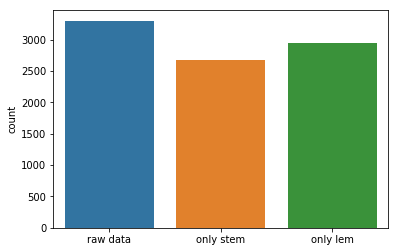

In [40]:
plt.figure()
sns.barplot(x = ['raw data','only stem','only lem'],
            y = [len(set(corpus_w_h)),len(set(stem_wo)),len(set(lem_wo))])
plt.ylabel('count')
plt.show()

- 去粗stopwords后的词频

In [46]:
# FreqDist(corpus_wo_h)

FreqDist({'good': 479,
          'quality': 47,
          'dog': 122,
          'food': 136,
          'advertised': 3,
          'delight': 7,
          'says': 3,
          'cough': 2,
          'medicine': 1,
          'great': 690,
          'taffy': 4,
          'nice': 48,
          'expensive': 21,
          'brands': 3,
          'wonderful': 44,

In [47]:
# list(FreqDist(corpus_wo_h).items())

[('good', 479),
 ('quality', 47),
 ('dog', 122),
 ('food', 136),
 ('advertised', 3),
 ('delight', 7),
 ('says', 3),
 ('cough', 2),
 ('medicine', 1),
 ('great', 690),
 ('taffy', 4),
 ('nice', 48),
 ('expensive', 21),
 ('brands', 3),
 ('wonderful', 44),
 ('tasty', 91),
 ('yay', 2),
 ('barley', 2),
 ('healthy', 63),

In [48]:
FreqDist(corpus_wo_h).most_common(10)

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [49]:
fdist_wo = pd.DataFrame(list(FreqDist(corpus_wo_h).items()), columns=['word wo','freq wo'])
fdist_wo.sort_values(by='freq wo',inplace=True,ascending=False)
fdist_wo.head()

,word wo,freq wo
9,great,690
0,good,479
19,best,341
24,love,215
38,taste,179


In [50]:
fdist_w = pd.DataFrame(list(FreqDist(corpus_w_h).items()),columns=['word w','freq w'])
fdist_w.sort_values(by='freq w',ascending=False,inplace=True)
fdist_w.head()

,word w,freq w
13,great,690
17,the,482
0,good,479
71,for,384
25,best,341


-----
# Issue 2 -내 생각
제일 많이 나오는 단어로 차트를 만드는건데 FreqDist().most_common()를 이용하면 어떨까?


In [51]:
freq_wo =FreqDist(corpus_wo_h).most_common(10) 
freq_wo

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [52]:
dict(freq_wo).items()

dict_items([('great', 690), ('good', 479), ('best', 341), ('love', 215), ('taste', 179), ('delicious', 164), ('chips', 162), ('product', 161), ('coffee', 141), ('tea', 140)])

In [53]:
freq_wo_df = pd.DataFrame(list(dict(freq_wo).items()),columns=['a','b'])
freq_wo_df.sort_values(by='b',ascending=False,inplace=True)
freq_wo_df

,a,b
0,great,690
1,good,479
2,best,341
3,love,215
4,taste,179
5,delicious,164
6,chips,162
7,product,161
8,coffee,141
9,tea,140


<p style='color:red'>내 생각 끝. 강의 코드 보다 복잡하다</p>

-----

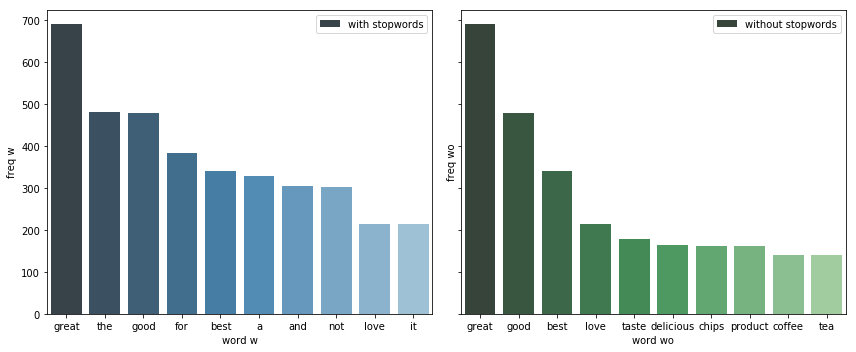

In [61]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,5))
sns.barplot(x=fdist_w['word w'][:10], 
            y=fdist_w['freq w'][:10],
            palette='Blues_d',ax=ax1,label='with stopwords')

sns.barplot(x=fdist_wo['word wo'][:10], 
            y=fdist_wo['freq wo'][:10],
            palette='Greens_d',ax=ax2,label='without stopwords')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### P.S. 热门短语

In [63]:
from nltk import ngrams

In [64]:
def get_ngrams(text,n=2):
    return ngrams(text,n)

In [69]:
s = 'what is your name'
s_token = word_tokenize(s)
list(get_ngrams(s_token))

[('what', 'is'), ('is', 'your'), ('your', 'name')]

In [74]:
bigram_w = []
for token in corpus_w_stopword:
    bigram = nltk.bigrams(token)
    for item in bigram:
        bigram_w.append(item)
bigram_wo = []
for token in corpus_wo_stopword:
    bigram = nltk.bigrams(token)
    for item in bigram:
        bigram_wo.append(item)

In [84]:
FreqDist(bigram_w).most_common(10)

[(('the', 'best'), 139),
 (('great', 'product'), 64),
 (('dog', 'food'), 60),
 (('love', 'it'), 58),
 (('great', 'for'), 51),
 (('gluten', 'free'), 48),
 (('very', 'good'), 47),
 (('love', 'this'), 44),
 (('hot', 'cocoa'), 43),
 (('a', 'great'), 42)]

In [78]:
FreqDist(bigram_wo).most_common(10)

[(('great', 'product'), 64),
 (('dog', 'food'), 60),
 (('gluten', 'free'), 48),
 (('hot', 'cocoa'), 43),
 (('great', 'taste'), 36),
 (('hot', 'chocolate'), 33),
 (('pretty', 'good'), 31),
 (('great', 'price'), 25),
 (('pop', 'chips'), 25),
 (('great', 'tasting'), 24)]

In [86]:
bi_fq_w = pd.DataFrame(list(FreqDist(bigram_w).items()), columns=['bi_w','bicounts_w'])
bi_fq_wo = pd.DataFrame(list(FreqDist(bigram_wo).items()), columns=['bi_wo','bicounts_wo'])

In [92]:
bi_fq_w.sort_values(by='bicounts_w',inplace=True,ascending=False)
bi_fq_wo.sort_values(by='bicounts_wo',inplace=True,ascending=False)

In [93]:
bi_fq_w.head()

,bi_w,bicounts_w
22,"(the, best)",139
425,"(great, product)",64
2,"(dog, food)",60
56,"(love, it)",58
173,"(great, for)",51


In [94]:
bi_fq_wo.head()

,bi_wo,bicounts_wo
277,"(great, product)",64
2,"(dog, food)",60
52,"(gluten, free)",48
4806,"(hot, cocoa)",43
68,"(great, taste)",36


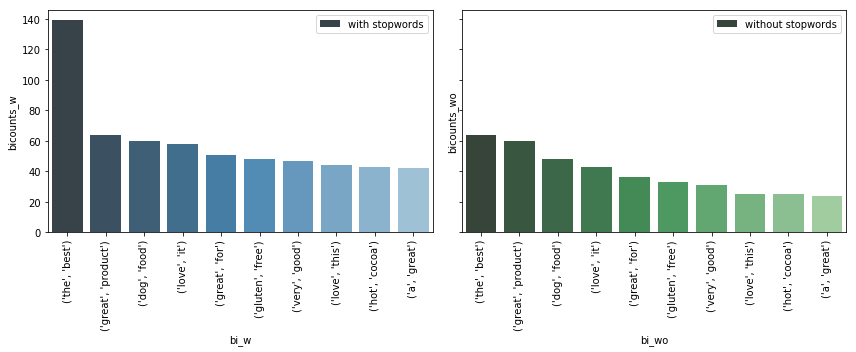

In [103]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,5))
sns.barplot(x=bi_fq_w['bi_w'][:10], 
            y=bi_fq_w['bicounts_w'][:10],
            palette='Blues_d',ax=ax1,label='with stopwords')

sns.barplot(x=bi_fq_wo['bi_wo'][:10], 
            y=bi_fq_wo['bicounts_wo'][:10],
            palette='Greens_d',ax=ax2,label='without stopwords')

ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=90)
ax2.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=90)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 4.4 Modeling
### 4.4.1 Data processing

In [105]:
def stem_tokens(tokens, stemmer = PorterStemmer()):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed     
    
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens)
    return ''.join(stems)

def build_corpus(dataset):
    corpus = []
    for text in dataset:
        corpus.append(tokenize(text))
    return corpus


In [109]:
n = 10000
X = summary[:n]
y = label[:n]

In [114]:
seed = 2018
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/5, random_state=seed)

- build corpus

In [122]:
train_token = build_corpus(X_train)
test_token = build_corpus(X_test)

In [123]:
FreqDist(test_token).most_common(10)

[('delici', 24),
 ('yummi', 24),
 ('greatproduct', 14),
 ('thebest', 12),
 ('great', 10),
 ('goodstuff', 9),
 ('awesom', 8),
 ('greatcoffe', 8),
 ('yum', 7),
 ('tastgreat', 7)]

In [124]:
FreqDist(train_token).most_common(10)

[('delici', 85),
 ('yummi', 71),
 ('greatproduct', 54),
 ('yum', 49),
 ('great', 41),
 ('loveit', 40),
 ('greatcoffe', 36),
 ('excel', 29),
 ('goodstuff', 27),
 ('thebest', 24)]

### 4.4.2 进一步处理，计算单词出现的tf-idf频率：sklearn TfidfVectorizer (会用就行)

1. 什么是TF-IDF？

2. TF: term frequency 具体单词在某篇文章中的出现次数 
3. $TF_{词i,文章j} = \frac{词i在文章j中的频率}{文章j中所有词的频率总和}$
4. IDF: inversed document frequency 
5. $IDF_{词i} = log \frac{所有文章的篇数总和}{带有词汇i的文章篇数总和}$


In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()

X_train_tfidf_vec = tfidf_vec.fit_transform(X_train)
X_test_tfidf_vec = tfidf_vec.fit_transform(X_test)

In [131]:
X_train_tfidf_vec.shape

(8000, 4232)

In [132]:
# for i in X_train_tfidf_vec:
#     print(i)
#     print('-----')

```
  (0, 3735)	0.24360750414756793
  (0, 1513)	0.5264995990860638
  (0, 1999)	0.2989781532488511
  (0, 1104)	0.4052683954906568
  (0, 1101)	0.3660027557635365
  (0, 3710)	0.1961331160269636
  (0, 1985)	0.4872339593589434
-----
  (0, 2416)	0.3600227421436003
  (0, 1824)	0.5413846747034812
  (0, 3705)	0.3279826020594771
  (0, 2286)	0.5413846747034812
  (0, 469)	0.42025742810580885
-----
  (0, 3010)	0.6169147139875941
  (0, 1588)	0.3669133633753244
  (0, 1991)	0.6962692147741503
-----
```

In [134]:
# tfidf_vec.get_feature_names()

['08',
 '081fl',
 '10',
 '100',
 '12',
 '16',
 '16ounce',
 '1866',
 '18month',
 '20',
 '200',
 '2199',
 '234',
 '24ounc',
 '2nd',
 '41',
 '45',
 '4oz',
 '50',
 '5hour',
 '6oz',
 '8ounce',
 '99',
 'about',
 'absolute',
 'absolutely',
 'absotively',
 'acceptable',
 'accurate',
 'acidic',
 'acquired',
 'across',
 'action',
 'actual',
 'actually',
 'adaptor',
 'add',
 'added',
 'addicitive',
 'addicted',
 'addicting',
 'addictive',
 'additions',
 'adds',
 'adequate',
 'adults',
 'advertised',
 'advertising',
 'afforable',
 'afford',
 'after',
 'afternoon',
 'aftertaste',
 'again',
 'agar',
 'agave',
 'agree',
 'ahhhh',
 'ahoy',
 'air',
 'alcoholic',
 'alergias',
 'alimenticias'

### 4.4.3 调用具体模型 train & predict

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [142]:
lr = LogisticRegression().fit(X_train_tfidf_vec,y_train)
ypred_lr = lr.predict(X_test_tfidf_vec)

ValueError: X has 1973 features per sample; expecting 4232

```
--------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-141-f5dd3b405b41> in <module>()
      1 lr = LogisticRegression().fit(X_train_tfidf_vec,y_train)
----> 2 ypred_lr = lr.predict(X_test_tfidf_vec)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py in predict(self, X)
    322             Predicted class label per sample.
    323         """
--> 324         scores = self.decision_function(X)
    325         if len(scores.shape) == 1:
    326             indices = (scores > 0).astype(np.int)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py in decision_function(self, X)
    303         if X.shape[1] != n_features:
    304             raise ValueError("X has %d features per sample; expecting %d"
--> 305                              % (X.shape[1], n_features))
    306 
    307         scores = safe_sparse_dot(X, self.coef_.T,

ValueError: X has 1973 features per sample; expecting 4232
```